In [1]:
from utils import sars2_genome_info, sars2_genome_seq, get_parent, add_syn_mut_attribute, add_mut_at_node_attr, add_changes_from_ref_attr
from utils_randomization import get_total_muts_on_tree, get_branch_lengths, randomize_mutations_on_tree_multinomial
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
from augur.utils import json_to_tree
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import json
import string
import requests

## Ratio of nonsynonymous to synonymous divergence 

Import the tree and convert to Bio Phylo format.

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-11-01.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [3]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

In [4]:
reference_sequence_aa, reference_sequence_nt = sars2_genome_seq()

Add information about synonymous mutations as an attribute of nodes on the tree

In [9]:
tree = add_syn_mut_attribute(tree)

Add an attribute to each node that lists all mutations that have occurred between the root and node

In [10]:
tree = add_changes_from_ref_attr(tree)

Generate temporal windows, starting at the date of of the root and extending for a length of time specified by "window_len"

In [11]:
first_timepoint = tree.root.node_attrs['num_date']['value']
last_timepoint = 0
for node in tree.find_clades():
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']
        
def make_time_windows(window_len):
    time_windows = np.arange(first_timepoint, last_timepoint, window_len).tolist()
    time_windows += [last_timepoint]
    return time_windows

For each time window, compute dN/dS for each isolate within the window. For each isolate, the following function finds gene-specific nonsynonymous and synonymous divergence and then calculates the dN/dS ratio. Divergence here is the Hamming distance from the root normalized by the total number of synonymous or nonsynonymous sites in the gene.

In [7]:
def find_nonsyn_syn_denominators():
    
    denominators = {}
    
    for gene,nt_seq in reference_sequence_nt.items():
        
        seq = str(nt_seq)
        aa_seq = str(reference_sequence_aa[gene])

        nonsyn_denominator = 0
        syn_denominator = 0

        all_nts = ['A', 'C', 'G', 'T']

        for pos in range(len(seq)):
            nt = seq[pos]
            if nt!='N':

                codon = math.floor(pos/3)
                codon_pos = pos-(codon*3)
                real_codon_aa = aa_seq[codon]

                all_other_nts = [x for x in all_nts if x != nt]
                for mutated_nt in all_other_nts: 
                    if codon_pos == 0:
                        mut_codon_nt = mutated_nt+seq[pos+1:(pos+3)]
                    elif codon_pos == 1:
                        mut_codon_nt = seq[pos-1]+mutated_nt+seq[pos+1]
                    elif codon_pos == 2:
                        mut_codon_nt = seq[(pos-2):pos]+mutated_nt

                    mut_codon_aa = Seq(mut_codon_nt).translate()

                    if mut_codon_aa!=real_codon_aa:
                        nonsyn_denominator+=1
                    elif mut_codon_aa==real_codon_aa:
                        syn_denominator+=1
                        
            
        denominators[gene] = {'nonsyn_denominator': nonsyn_denominator, 'syn_denominator':syn_denominator}
        
    return denominators

Calculate the total number of nonsynonymous or synonymous sites (denominators)

In [8]:
denominators = find_nonsyn_syn_denominators()

In [19]:
def find_divergence_in_window(window_len=0.2):
    time_windows = make_time_windows(window_len)
    
#     window_divergence_info = []
    window_dnds_info = []
    
    # look at divergence within time window
    for x in range(1,len(time_windows)):
        start_date = time_windows[x-1]
        end_date = time_windows[x]
        
        s1_div_in_window = []
        s1_syn_div_in_window = []
        rdrp_div_in_window = []
        rdrp_syn_div_in_window = []

        for node in tree.find_clades():
            if node.node_attrs['num_date']['value']>=start_date and  node.node_attrs['num_date']['value']<=end_date:
                
                if len(node.get_terminals())>=3:
                    
                    s1_nonsyn_denom, s1_syn_denom = denominators['S1']['nonsyn_denominator'], denominators['S1']['syn_denominator']
                    
                                 

                    s1_div = len(node.node_attrs["changes_from_ref"]['s1_non'])/s1_nonsyn_denom
                    
                    #assign a false count to avoid dividing by zero
                    if len(node.node_attrs["changes_from_ref"]['s1_syn']) == 0:
                        s1_syn_div = 1/s1_syn_denom
                    else:
                        s1_syn_div = (len(node.node_attrs["changes_from_ref"]['s1_syn'])+1)/s1_syn_denom
                    
                    
                    s1_n_over_s = s1_div/s1_syn_div

                    
                    rdrp_nonsyn_denom, rdrp_syn_denom = denominators['RdRp']['nonsyn_denominator'], denominators['RdRp']['syn_denominator']

                    rdrp_div = len(node.node_attrs["changes_from_ref"]['rdrp_non'])/rdrp_nonsyn_denom
                    if len(node.node_attrs["changes_from_ref"]['rdrp_syn']) == 0:
                        rdrp_syn_div = 1/rdrp_syn_denom
                    else:
                        rdrp_syn_div = (len(node.node_attrs["changes_from_ref"]['rdrp_syn'])+1)/rdrp_syn_denom
                        
                    rdrp_n_over_s = rdrp_div/rdrp_syn_div
                    

                    e_nonsyn_denom, e_syn_denom = denominators['E']['nonsyn_denominator'], denominators['E']['syn_denominator']

                    e_div = len(node.node_attrs["changes_from_ref"]['e_non'])/e_nonsyn_denom
                    if len(node.node_attrs["changes_from_ref"]['e_syn']) == 0:
                        e_syn_div = 1/e_syn_denom
                    else:
                        e_syn_div = (len(node.node_attrs["changes_from_ref"]['e_syn'])+1)/e_syn_denom
                        
                    e_n_over_s = e_div/e_syn_div
                    
                    

                    n_nonsyn_denom, n_syn_denom = denominators['N']['nonsyn_denominator'], denominators['N']['syn_denominator']
                    
                    n_div = len(node.node_attrs["changes_from_ref"]['n_non'])/n_nonsyn_denom
                    if len(node.node_attrs["changes_from_ref"]['n_syn']) == 0:
                        n_syn_div = 1/n_syn_denom
                    else:
                        n_syn_div = (len(node.node_attrs["changes_from_ref"]['n_syn'])+1)/n_syn_denom
                        
                    n_n_over_s = n_div/n_syn_div
                    
                    
                    m_nonsyn_denom, m_syn_denom = denominators['M']['nonsyn_denominator'], denominators['M']['syn_denominator']

                    m_div = len(node.node_attrs["changes_from_ref"]['m_non'])/m_nonsyn_denom
                    if len(node.node_attrs["changes_from_ref"]['m_syn']) == 0:
                        m_syn_div = 1/m_syn_denom
                    else:
                        m_syn_div = (len(node.node_attrs["changes_from_ref"]['m_syn'])+1)/m_syn_denom
                        
                    m_n_over_s = m_div/m_syn_div
                    
    
                    s2_nonsyn_denom, s2_syn_denom = denominators['S2']['nonsyn_denominator'], denominators['S2']['syn_denominator']

                    s2_div = len(node.node_attrs["changes_from_ref"]['s2_non'])/s2_nonsyn_denom
                    if len(node.node_attrs["changes_from_ref"]['s2_syn']) == 0:
                        s2_syn_div = 1/s2_syn_denom
                    else:
                        s2_syn_div = (len(node.node_attrs["changes_from_ref"]['s2_syn'])+1)/s2_syn_denom
                        
                    s2_n_over_s = s2_div/s2_syn_div
                    
                    
                    nsp6_nonsyn_denom, nsp6_syn_denom = denominators['Nsp6']['nonsyn_denominator'], denominators['Nsp6']['syn_denominator']

                    
                    nsp6_div = len(node.node_attrs["changes_from_ref"]['nsp6_non'])/nsp6_nonsyn_denom
                    if len(node.node_attrs["changes_from_ref"]['nsp6_syn']) == 0:
                        nsp6_syn_div = 1/nsp6_syn_denom
                    else:
                        nsp6_syn_div = (len(node.node_attrs["changes_from_ref"]['nsp6_syn'])+1)/nsp6_syn_denom
                        
                    nsp6_n_over_s = nsp6_div/nsp6_syn_div
                    
                    
                    orf7a_nonsyn_denom, orf7a_syn_denom = denominators['ORF7a']['nonsyn_denominator'], denominators['ORF7a']['syn_denominator']

                    orf7a_div = len(node.node_attrs["changes_from_ref"]['orf7a_non'])/orf7a_nonsyn_denom
                    if len(node.node_attrs["changes_from_ref"]['orf7a_syn']) == 0:
                        orf7a_syn_div = 1/orf7a_syn_denom
                    else:
                        orf7a_syn_div = (len(node.node_attrs["changes_from_ref"]['orf7a_syn'])+1)/orf7a_syn_denom
                        
                    orf7a_n_over_s = orf7a_div/orf7a_syn_div
                    
                        
                        
                        
                        
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':s1_n_over_s, 'location': 'S1'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':rdrp_n_over_s, 'location': 'RdRp'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':e_n_over_s, 'location': 'E'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':n_n_over_s, 'location': 'N'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':m_n_over_s, 'location': 'M'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':s2_n_over_s, 'location': 'S2'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':nsp6_n_over_s, 'location': 'Nsp6'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':orf7a_n_over_s, 'location': 'ORF7a'})




        
                

    window_dnds_df = pd.DataFrame(window_dnds_info)
        

    return window_dnds_df
        

Generate a dataframe containing dN/dS information for each gene and temporal window

In [20]:
window_dnds = find_divergence_in_window()

Find the overall mean dn/ds in S1 and the dn/ds in 2021

In [21]:
mean_overall = window_dnds[window_dnds['location']=='S1']['dn/ds'].mean()
print(f'Overall mean dn/ds in S1: {mean_overall}')

mean_2021 = window_dnds[(window_dnds['location']=='S1')& (window_dnds['window_start']>=2020.9)]['dn/ds'].mean()
print(f'2021 mean dn/ds in S1: {mean_2021}')

Overall mean dn/ds in S1: 0.8796305578153218
2021 mean dn/ds in S1: 1.5220395037931613


In [22]:
window_dnds[(window_dnds['location']=='S1')& (window_dnds['window_start']>=2020.55)]['dn/ds'].mean()

1.3118208885967286

Plot dN/dS over time for each gene

This code generates Figure 2.

Text(0.08, 0.28, 'H3N2 HA1')

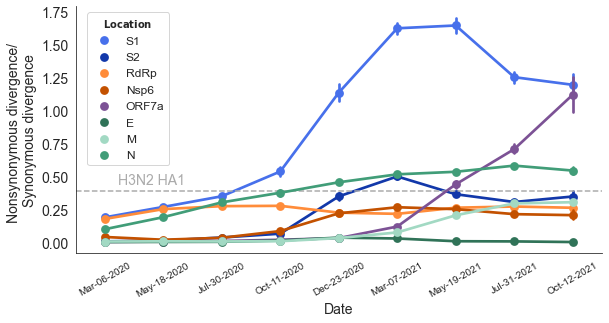

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
plt.tight_layout()
sns.set_style("white")
cmap = {'RdRp':"#ff8c3a", 'S1':"#4770eb", 'E': '#307358', 'N': '#419D78', 
        'M': '#a2d9c3', 'S2': '#1238aa', 'Nsp6':"#c35100", 'ORF7a':'#7c5295'}

sns.pointplot(x='window_end', y='dn/ds', hue='location', palette=cmap,
              data=window_dnds, hue_order=['S1', 'S2', 'RdRp', 'Nsp6', 'ORF7a', 'E', 'M', 'N'],
              ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Nonsynonymous divergence/ \nSynonymous divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xticks([p for p in ax.get_xticks()])
ax.set_xticklabels([DateToStr(float(t.get_text())) for t in ax.get_xticklabels()], rotation=30)


handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', fontsize=12, bbox_to_anchor=(0.1, 1.0), 
                 title = r'$\bf{Location}$')
ax.axhline(y=0.39, color="#ABABAB", linestyle = '--')
ax.annotate(text='H3N2 HA1', xy=(0.08, 0.28), xycoords='axes fraction', color="#ABABAB", fontsize=14)

# fig.savefig('plots/divergence_2021-11-01.png', dpi=300, bbox_inches='tight')